In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors 
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from PIL import Image 
import geopandas
import geoplot
from geopandas import GeoDataFrame

%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swaterman/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ModuleNotFoundError: No module named 'geopandas'

In [ ]:
airbnb = pd.read_csv('Airbnb_Open_Data.csv')
airbnb.head()

/var/folders/st/xx5ph4vs1hlcdq7v57kk3h6h0000gn/T/ipykernel_51786/655177850.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb = pd.read_csv('Airbnb_Open_Data.csv')


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [ ]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [ ]:
airbnb.isnull().sum()

NAME                                 250
host_identity_verified            102599
host name                            406
neighbourhood group                    0
neighbourhood                         16
lat                                    8
long                                   8
instant_bookable                     105
cancellation_policy                   76
room type                              0
Construction year                    214
price                                  0
service fee                          273
minimum nights                       409
number of reviews                    183
reviews per month                  15879
review rate number                   326
calculated host listings count       319
availability 365                     448
house_rules                        52131
dtype: int64

# Data Cleaning

In [ ]:
# drop the column we do not use
airbnb = airbnb.drop(['id', 'host id','country','country code','license','last review',''], axis=1)
airbnb.head(2)

,NAME,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365,house_rules
0,Clean & quiet apt home by the park,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,$966,$193,10.0,9.0,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...
1,Skylit Midtown Castle,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...


In [ ]:
# change host_identity_verified to binary int
airbnb['host_identity_verified'] = airbnb['host_identity_verified'].map({'verified': 1, 'unconfirmed': 0})

# combine the same group for neighbourhood group
airbnb['neighbourhood group'] = airbnb['neighbourhood group'].replace('brookln', 'Brooklyn').replace('manhatan', 'Manhattan')

# Fill missing values in the 'neighbourhood group' column with a placeholder (e.g., 'Unknown')
airbnb['neighbourhood group'].fillna('Unknown', inplace=True)

# Apply the function to fill missing prices
airbnb['price'] = airbnb['price'].replace('[\$,]', '', regex=True)
airbnb['service fee'] = airbnb['service fee'].replace('[\$,]', '', regex=True)

# Convert the "price" column to a float data type
airbnb['price'] = airbnb['price'].astype(float)
airbnb['service fee'] = airbnb['service fee'].astype(float)

# Calculate the average price for each neighborhood group
average_prices = airbnb.groupby('neighbourhood group')['price'].mean()

# Function to fill missing prices with the average price of the neighborhood group
def fill_missing_price(row):
    if pd.isnull(row['price']):
        return average_prices[row['neighbourhood group']]
    else:
        return row['price']

# Apply the function to update missing prices
airbnb['price'] = airbnb.apply(fill_missing_price, axis=1)



## Service Fee vs Price

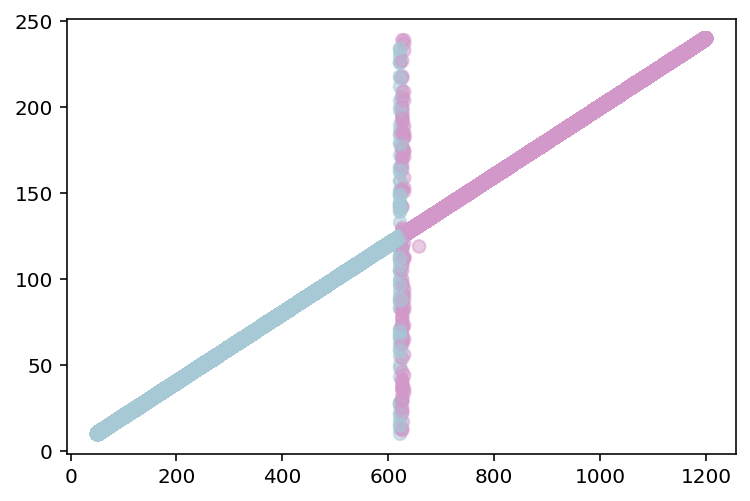

In [ ]:
eng_mean =  airbnb['price'].mean()
col = np.where(airbnb['price']<eng_mean, '#A7C8D5', '#D298C9')
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(airbnb['price'], airbnb['service fee'],c=col, s=40, alpha=0.5)
plt.show()

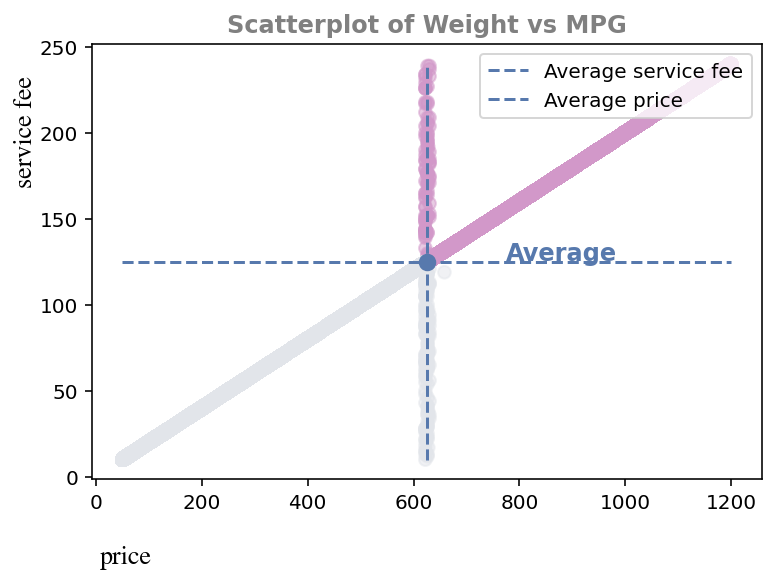

In [ ]:
#Calculate the mean MPG and mean WGT
my = airbnb['service fee'].mean()
mx = airbnb['price'].mean()

#Add color scheme by condition: if MPG<mean, '#E2E5EA', ow '#E15F32'
col = np.where(airbnb['service fee']<my, '#E2E5EA', '#D298C9')

#Draw scatter plot, use col as our color scheme
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(airbnb['price'], airbnb['service fee'], c=col, s=40, alpha=0.5)

#Add horizontal line to indicate mean MPG
wgt=airbnb['price']
ax.hlines(y=my, xmin=wgt.min(), xmax=wgt.max(), 
          colors='#5779AD', linestyles='dashed', lw=1.5, label='Average service fee')

mpg=airbnb['service fee']
ax.vlines(x=mx, ymin=mpg.min(), ymax=mpg.max(), 
          colors='#5779AD', linestyles='dashed', lw=1.5, label='Average price')

#Add the a reference point to indicate mean MPG and mean WGT
ax.scatter(mx, my, c='#5779AD', s=60) #plot the point
#Add text
ax.annotate('Average', 
             (mx+150, my+1),
             c='#5779AD',
             size=12, weight='bold') 

#Show legend for the label of the line
ax.legend(loc="upper right")

#Add title, xlabel and ylabel
ax.set_xlabel("price",fontsize=13, fontname="Times")
ax.set_ylabel("service fee",fontsize=13, fontname="Times")
ax.set_title("Scatterplot of Weight vs MPG",c='grey', weight = 'bold')

#set x label position to bottom left
ax.xaxis.set_label_coords(0.05, -0.15) 
#set y label position to top right
ax.yaxis.set_label_coords(-0.08, 0.8)

# #hide the frames, only show x and y axis
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.show()

## Price vs Room Type

In [ ]:
airbnb['room type'].value_counts()

Entire home/apt    53701
Private room       46556
Shared room         2226
Hotel room           116
Name: room type, dtype: int64

In [ ]:
average_price_rt = airbnb.groupby('neighbourhood group','room type')['price'].mean()
average_price_rt

ValueError: No axis named room type for object type DataFrame

In [ ]:
rm_price_info = airbnb.groupby(['neighbourhood group','room type']).agg({'price': ['mean', 'min', 'max','count']})
rm_price_info

price                      
                                           mean    min     max  count
neighbourhood group room type                                        
Bronx               Entire home/apt  620.254696   50.0  1200.0   1022
                    Private room     634.692985   50.0  1200.0   1573
                    Shared room      600.256410   63.0  1171.0    117
Brooklyn            Entire home/apt  626.874751   50.0  1200.0  20574
                    Hotel room       736.125000  246.0  1082.0      8
                    Private room     625.879276   50.0  1200.0  20433
                    Shared room      634.270067   50.0  1197.0    825
Manhattan           Entire home/apt  623.154783   50.0  1200.0  26472
                    Hotel room       681.870000   50.0  1193.0    100
                    Private room     620.382053   50.0  1200.0  16310
                    Shared room      632.488765   50.0  1199.0    907
Queens              Entire home/apt  627.038418   50.0  1200.0   5146
                    Hotel room       433.250000  157.0   912.0      8
                    Private room     631.862471   50.0  1200.0   7750
                    Shared room      645.306630   50.0  1198.0    362
Staten Island       Entire home/apt  642.155043   50.0  1196.0    474
                    Private room     603.590088   50.0  1200.0    466
                    Shared room      715.600000  182.0  1162.0     15
Unknown             Entire home/apt  689.668831  252.0  1133.0     11
                    Private room     639.222222   54.0  1083.0     18

In [ ]:
median_price_rt = airbnb.groupby('room type')['price'].median()
median_price_rt

room type
Entire home/apt    624.0
Hotel room         644.5
Private room       623.0
Shared room        649.5
Name: price, dtype: float64

In [ ]:
average_price_rt

room type
Entire home/apt    625.078352
Hotel room         668.465517
Private room       625.029167
Shared room        634.099333
Name: price, dtype: float64

In [ ]:
x = ['Private room','Entire home/apt','Shared room','Hotel room']
y = sorted(round(average_price_rt,2))

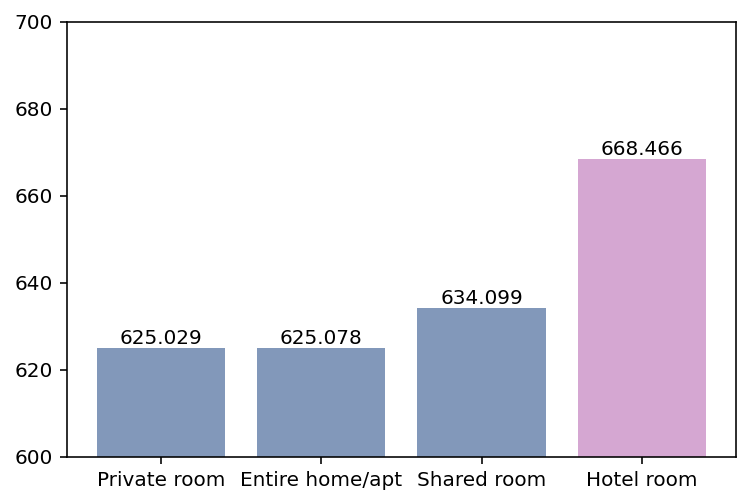

In [ ]:
fig, ax = plt.subplots(figsize= (6,4))
colors = [ '#8298ba', '#8298ba','#8298ba','#D5A7D2']

ax.bar(x,sorted(average_price_rt), color = colors)
plt.ylim(600, 700)
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

## Price VS Lat&Long

In [ ]:

#Check quantiles of population
airbnb['price'].quantile([.0, 0.25, .5, 0.75,  1])

0.00      50.0
0.25     340.0
0.50     624.0
0.75     913.0
1.00    1200.0
Name: price, dtype: float64

In [ ]:
#Make color scheme based on the quantiles
def conditions_color(airbnb):
    if airbnb['price'] < 340:
        return '#A4BFD3'
    elif (airbnb['price'] >= 340)& (airbnb['price'] < 624):
        return '#D0A4D3'
    elif (airbnb['price'] >= 624)& (airbnb['price'] < 913):
        return '#F8E857'
    else:
        return '#FAB74B'

In [ ]:
#Define a new column storing the colors
airbnb['Color'] = airbnb.apply(conditions_color, axis=1)

In [ ]:
#Similarly define labels for population
def conditions_label(airbnb):
    if airbnb['price'] < 340:
        return '0-25% price size'
    elif (airbnb['price'] >= 340)& (airbnb['price'] < 624):
        return '25%-50% price size'
    elif (airbnb['price'] >= 624)& (airbnb['price'] < 913):
        return '50%-75% price size'
    else:
        return '75%-100% price size'

In [ ]:
airbnb['Label'] = airbnb.apply(conditions_label, axis=1)

In [ ]:
#Seperate data by population size
df_1 = airbnb[airbnb['Label']=='0-25% price size']
df_2 = airbnb[airbnb['Label']=='25%-50% price size']
df_3 = airbnb[airbnb['Label']=='50%-75% price size']
df_4 = airbnb[airbnb['Label']=='75%-100% price size']

In [ ]:
#Find few states with different characteristics
dot_1 = airbnb[airbnb['service fee']==airbnb['service fee'].min()]
dot_2 = airbnb[airbnb['review rate number']==airbnb['review rate number'].max()]
dot_3 = airbnb[airbnb['price']==airbnb['price'].max()]

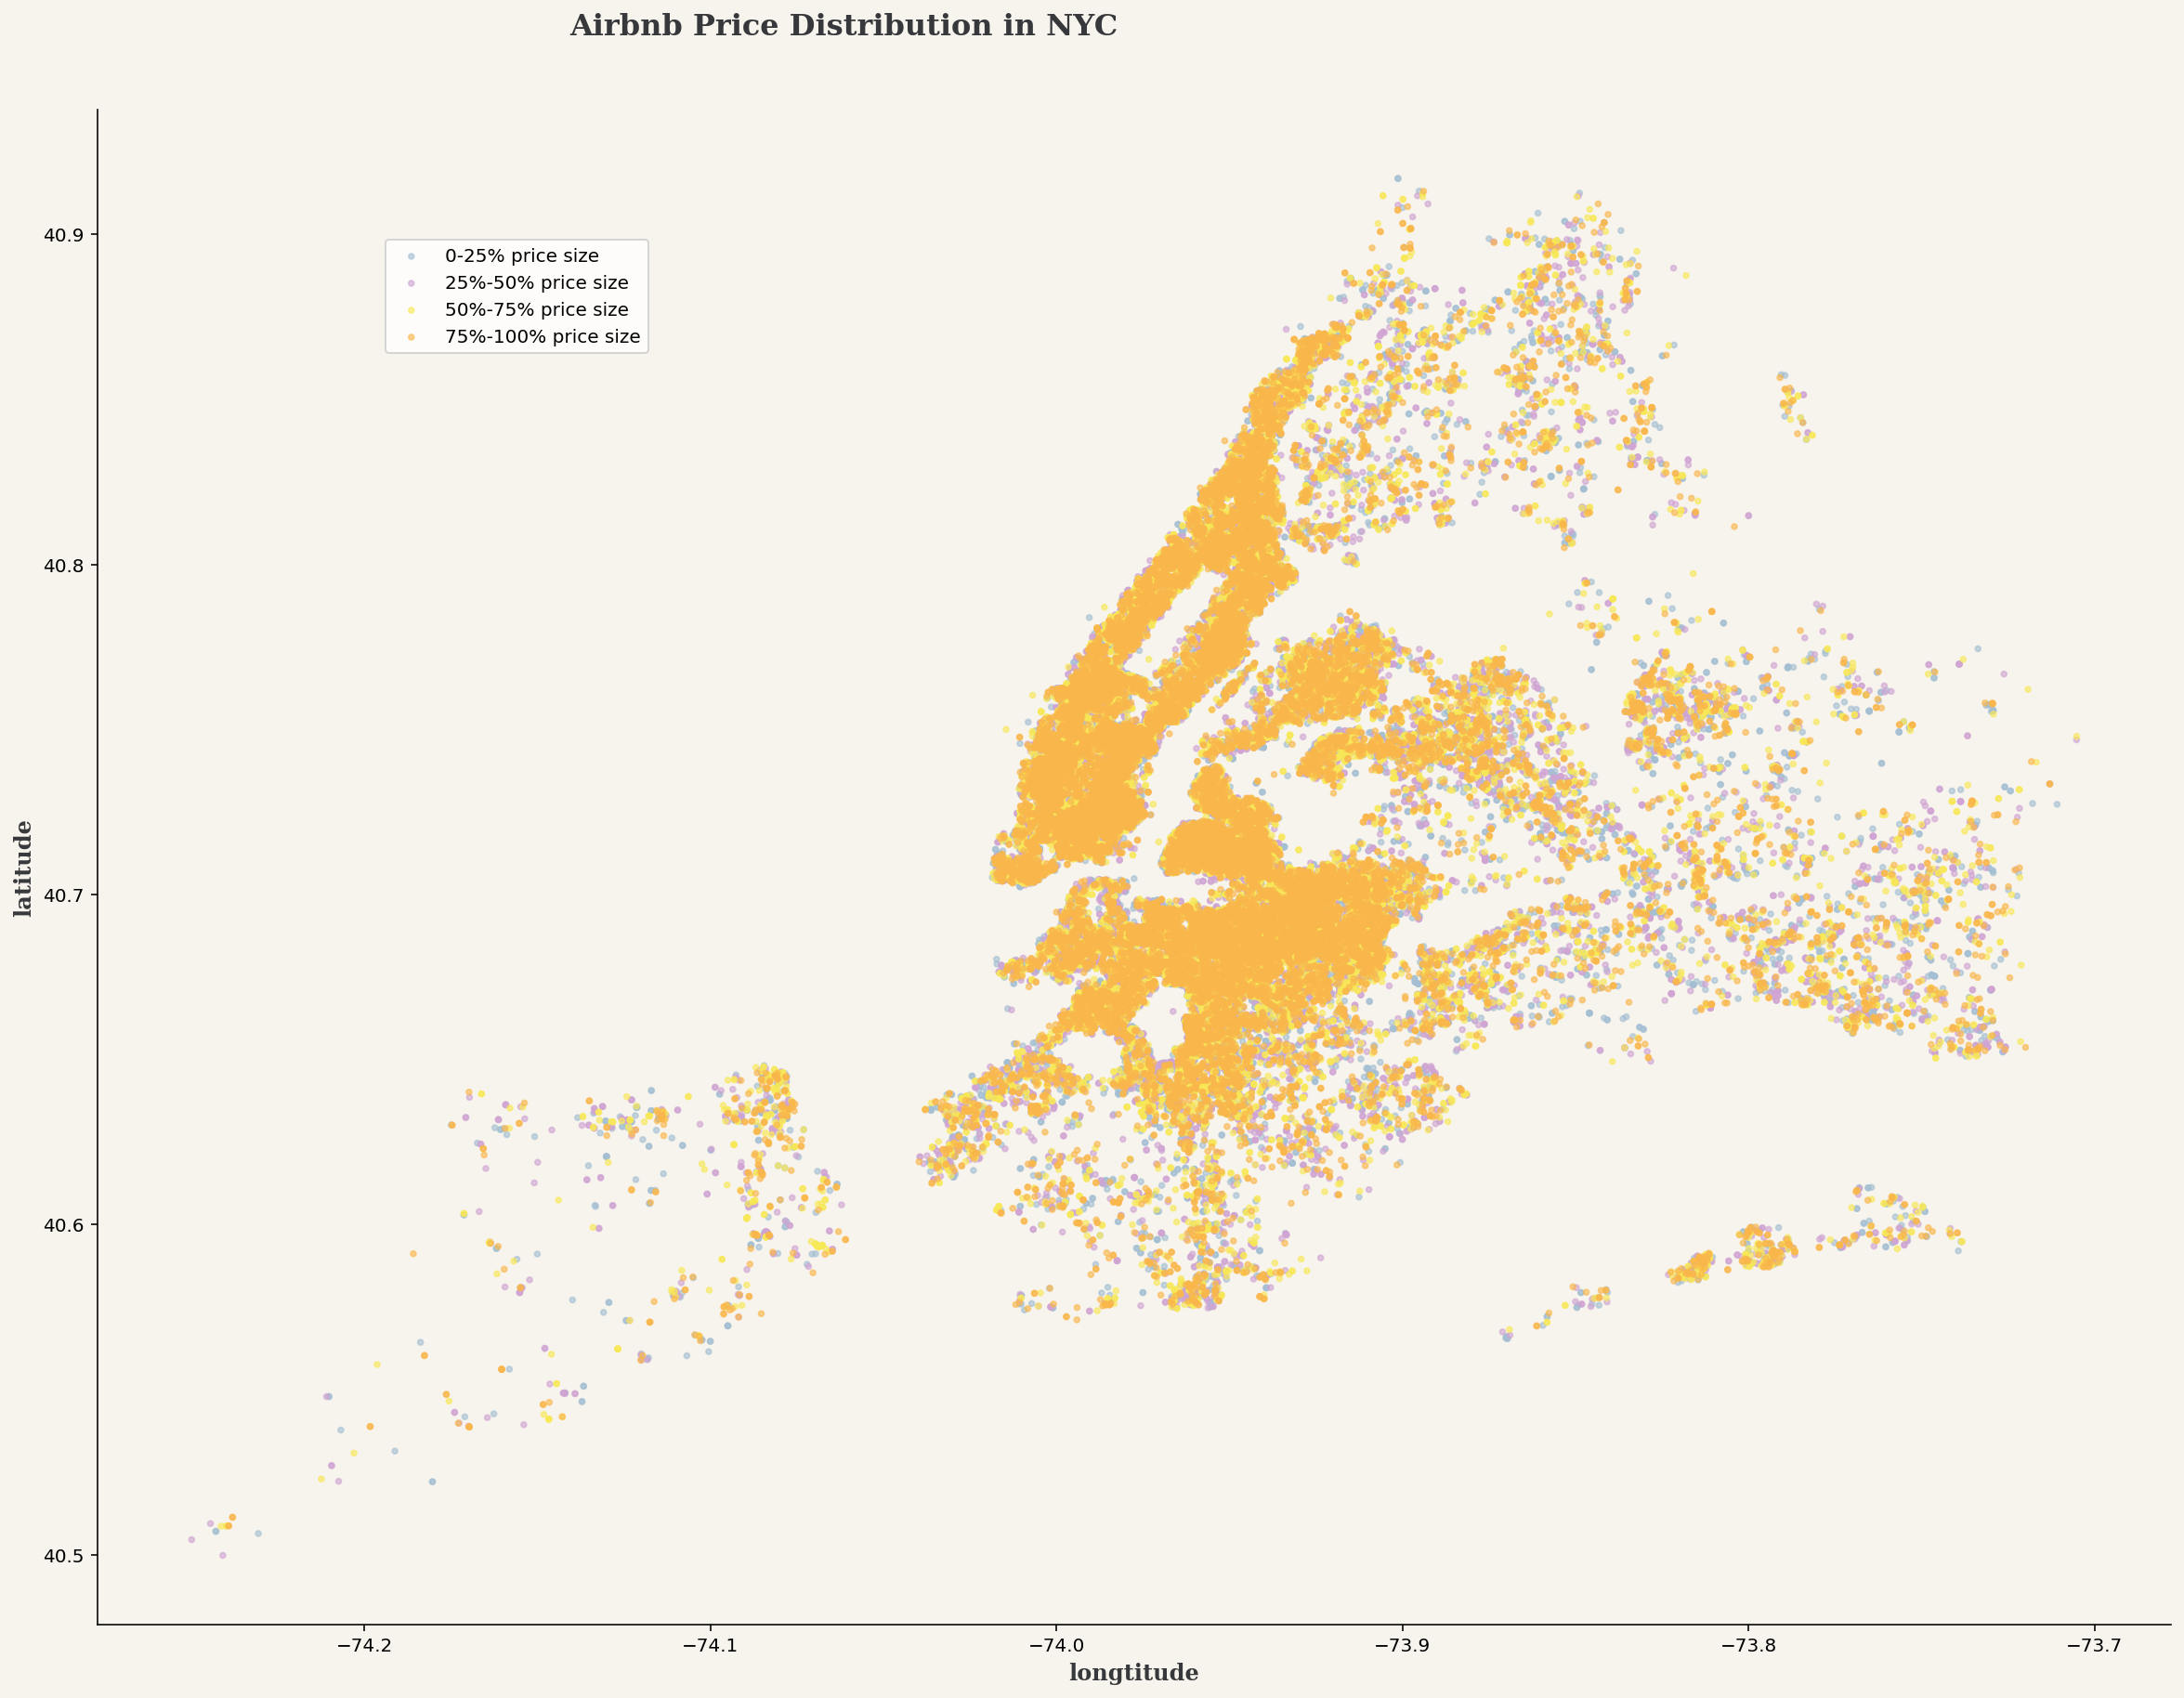

In [ ]:
#Scatter plot 
fig, ax = plt.subplots(figsize=(20,15))



#Scatter plot for each population size to generate legend
ax.scatter(df_1['long'], df_1['lat'], c=df_1['Color'], s=8, alpha=0.6, label = '0-25% price size')
ax.scatter(df_2['long'], df_2['lat'], c=df_2['Color'], s=8, alpha=0.6, label = '25%-50% price size')
ax.scatter(df_3['long'], df_3['lat'], c=df_3['Color'], s=8, alpha=0.6, label = '50%-75% price size')
ax.scatter(df_4['long'], df_4['lat'], c=df_4['Color'], s=8, alpha=0.6, label = '75%-100% price size')
ax.legend(loc="upper right",bbox_to_anchor=(0.27,0.92))



#Add title and labels
ax.set_title("Airbnb Price Distribution in NYC",fontweight='bold',color='#37383b',
             fontsize=16,fontname='serif',pad=40,x=0.36,y=1)
ax.set_xlabel('longtitude',fontsize=12,fontname='serif',color='#37383b',weight='bold')
ax.set_ylabel('latitude',fontsize=12,fontname='serif',color='#37383b',weight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#add background color
ax.set_facecolor(color='#f7f4ed')
fig.patch.set_facecolor('#f7f4ed')

plt.show()

In [ ]:
# Plot a geo plot
crs={'init':'epsg:4326'}
boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))
geo_df=geopandas.GeoDataFrame(df,crs=crs,geometry=geopandas.points_from_xy(df["long"], df["lat"]))

NameError: name 'geopandas' is not defined

In [ ]:
# Plot a geo plot
crs={'init':'epsg:4326'}
boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))
geo_df=geopandas.GeoDataFrame(df,crs=crs,geometry=geopandas.points_from_xy(df["long"], df["lat"]))

In [ ]:
import folium


# Create a map centered at the mean latitude and longitude of the listings
map_center = [airbnb['lat'].mean(), data['long'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

airbnb.dropna(subset=['lat', 'long'], inplace=True)

# Define a function to assign marker color based on price range
def conditions_color(airbnb):
    if airbnb['price'] < 340:
        return '#A4BFD3'
    elif (airbnb['price'] >= 340)& (airbnb['price'] < 624):
        return '#D0A4D3'
    elif (airbnb['price'] >= 624)& (airbnb['price'] < 913):
        return '#F8E857'
    else:
        return '#FAB74B'
    
#Define a new column storing the colors
airbnb['Color'] = airbnb.apply(conditions_color, axis=1)

# Add markers to the map for each listing
for index, row in airbnb.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=5,
        popup=f"Price: ${row['price']:.2f}\nRoom Type: {row['room type']}",
        fill=True,
        fill_color=row['Color'],
        color='grey',
        fill_opacity=0.7
    ).add_to(mymap)

# Display the map
mymap.save('airbnb_map.html')


## Word clouds

In [ ]:
# First, strip to remove the space from the beginning and end, then normalize the text to be low
airbnb['house_rules'] = airbnb['house_rules'].str.strip().str.lower()

# Now combine the strings from all rows in that column, separating them by space
text = airbnb['house_rules'].str.cat(sep=' ')
print(f"There are {len(text):,d} chars")
text[0:100]

There are 14,482,812 chars


"clean up and treat the home the way you'd like your home to be treated.  no smoking. pet friendly bu"

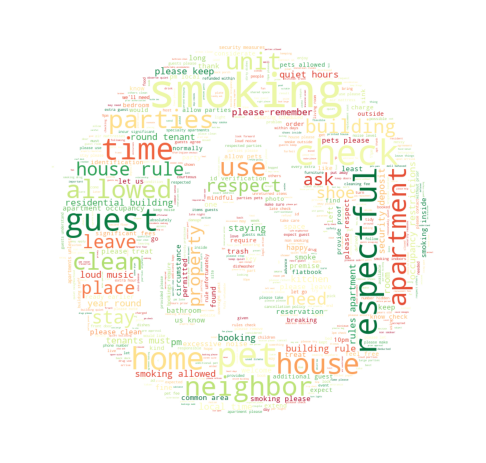

In [ ]:
stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(background_color='white', mask = airbnb_logo,stopwords=stop_words,
                       width = airbnb_logo.shape[1],height = airbnb_logo.shape[0], 
                      max_words=2000,max_font_size = 500,colormap='RdYlGn')
wordcloud.generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [ ]:
wordcloud.to_file('airbnb.png')

In [ ]:
airbnb_logo = np.array(Image.open('5.png'))
airbnb_logo

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [245, 245, 245]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [245, 245, 245]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [245, 245, 245]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [245, 245, 245]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [245, 245, 245]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [245, 245, 245]]